# Causal Inference

Let's learn about causal inference using Bayesian Belief Networks (BBN).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
np.random.seed(37)

## Gender, drug and recovery

Imagine that we have an illness or disease, and that some patients were given a drug and some were not for treatment. We kept good records of three variables.

* gender: whether the patient was female or male
* drug: whether the patient took the drug or not
* recovery: whether the patient recovered from the illness

We can model the interactions of these variables using a BBN. 

### Structure

The structure of a BBN is a directed acyclic graph `DAG`. We will visualize the structure later, but for now, the relationships in the model is as follows.

* gender $\rightarrow$ drug
* gender $\rightarrow$ recovery
* drug $\rightarrow$ recovery

### Parameters

For each variable, we need to define `local probability models`, and, here, they come in the form of `conditional probability tables`.

In [2]:
gender_probs = [0.49, 0.51]

print(gender_probs)

[0.49, 0.51]


In [3]:
drug_probs = [0.23323615160349853, 0.7667638483965015,
              0.7563025210084033, 0.24369747899159663]

print(drug_probs[0:2])
print(drug_probs[2:4])

[0.23323615160349853, 0.7667638483965015]
[0.7563025210084033, 0.24369747899159663]


In [4]:
recovery_probs = [0.31000000000000005, 0.69, 
                  0.27, 0.73, 
                  0.13, 0.87, 
                  0.06999999999999995, 0.93]

print(recovery_probs[0:2])
print(recovery_probs[2:4])
print(recovery_probs[4:6])
print(recovery_probs[6:8])

[0.31000000000000005, 0.69]
[0.27, 0.73]
[0.13, 0.87]
[0.06999999999999995, 0.93]


### Bayesian network

With the structure and parameters defined, now we can build a BBN.

In [5]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

X = BbnNode(Variable(1, 'drug', ['false', 'true']), drug_probs)
Y = BbnNode(Variable(2, 'recovery', ['false', 'true']), recovery_probs)
Z = BbnNode(Variable(0, 'gender', ['female', 'male']), gender_probs)

bbn = Bbn() \
    .add_node(X) \
    .add_node(Y) \
    .add_node(Z) \
    .add_edge(Edge(Z, X, EdgeType.DIRECTED)) \
    .add_edge(Edge(Z, Y, EdgeType.DIRECTED)) \
    .add_edge(Edge(X, Y, EdgeType.DIRECTED))

### Visualize Bayesian network structure

Let's see the structure of this network.

In [6]:
g, labels = bbn.to_nx_graph()

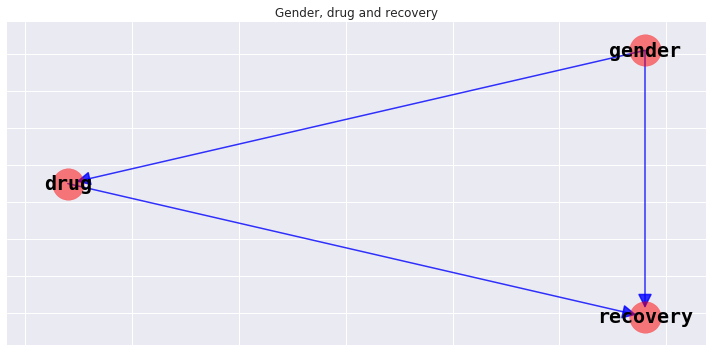

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

pos = nx.nx_agraph.graphviz_layout(g, prog='dot', args='-Kdot')

params = {
    'node_color': 'r',
    'node_size': 1000,
    'node_shape': 'o',
    'alpha': 0.5,
    'pos': pos,
    'ax': ax
}
_ = nx.drawing.nx_pylab.draw_networkx_nodes(g, **params)

params = {
    'labels': labels,
    'font_size': 20,
    'font_color': 'k',
    'font_family': 'monospace',
    'font_weight': 'bold',
    'pos': pos,
    'ax': ax
}
_ = nx.drawing.nx_pylab.draw_networkx_labels(g, **params)

params = {
    'width': 1.5,
    'alpha': 0.8,
    'edge_color': 'b',
    'arrowsize': 30,
    'pos': pos,
    'ax': ax
}
_ = nx.drawing.nx_pylab.draw_networkx_edges(g, **params)

_ = ax.set_title('Gender, drug and recovery')

plt.tight_layout()

## Sample data

Let's sample some data from the BBN and observe some summary statistics about the sampled data. Additionally, the data will help us answer if taking the drug does really help in recovery.

In [8]:
from pybbn.sampling.sampling import LogicSampler

sampler = LogicSampler(bbn)
data = pd.DataFrame(sampler.get_samples(n_samples=10000, seed=37))
data = data.rename(columns=labels)

## Simpson's paradox

In general, the sample population made good recovery (80%).

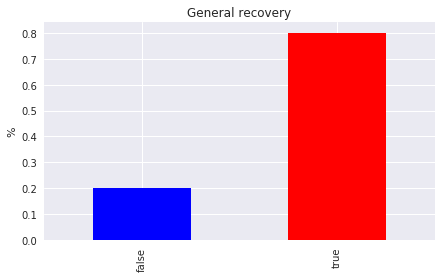

In [9]:
s = data.recovery.value_counts().sort_index()
s /= s.sum()

fig, ax = plt.subplots(figsize=(7, 4))
_ = s.plot.bar(ax=ax, color=['b', 'r'])
_ = ax.set_title('General recovery')
_ = ax.set_ylabel('%')

If we segment recovery by whether or not a patient takes the drug, we find that 

* `82%` of patients recovered if they did **NOT** take the drug, compared to `78%` if they did take the drug (not taking the drug **increases** your chance of recovery), and
* `18%` of the patients did **NOT** recover if they did **NOT** take the drug, compared to `22%` if they did **NOT** recover but did take the drug (not taking the drug **decreases** of chance of not recovering). 

The comparison might lead one to interpret the outcome that **NOT** taking the drug gives us a better chance of recovery.

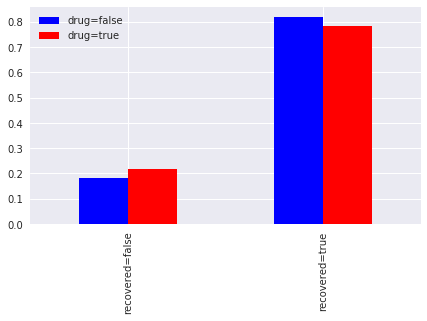

In [10]:
s0 = data[data.drug == 'false'].recovery.value_counts().sort_index()
s0 /= s0.sum()

s1 = data[data.drug == 'true'].recovery.value_counts().sort_index()
s1 /= s1.sum()

fig, ax = plt.subplots(figsize=(7, 4))
_ = pd.DataFrame(
    [[s0[0], s1[0]], [s0[1], s1[1]]], 
    columns=['drug=false', 'drug=true'], 
    index=['recovered=false', 'recovered=true']).plot.bar(ax=ax, color=['b', 'r'])

Now, we segment based on gender. Notice 

* for both females and males, taking the drug did increase recovery, and
* for both females and males, not taking the drug did decrease non-recovery.

The observation here contradicts the one we had before without segmenting on gender. Before, not taking the drug was helpful, now, segmenting on gender, not taking the drug is harmful. This contradiction is `Simpson's paradox`. So is taking the drug helpful or harmful?

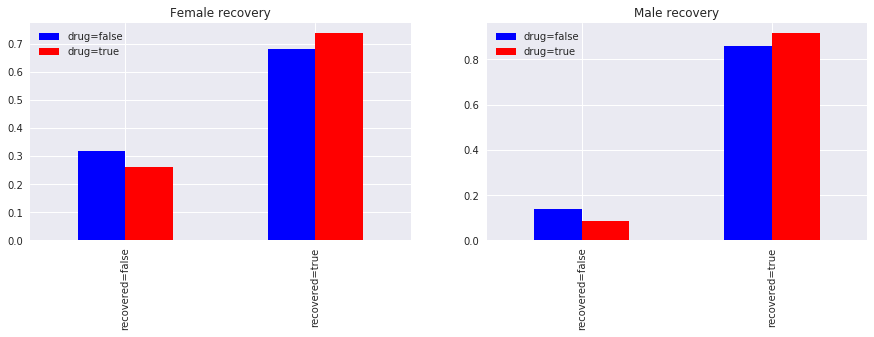

In [11]:
df = data[data.gender == 'female']

s0 = df[df.drug == 'false'].recovery.value_counts().sort_index()
s0 /= s0.sum()

s1 = df[df.drug == 'true'].recovery.value_counts().sort_index()
s1 /= s1.sum()

f_df = pd.DataFrame(
    [[s0[0], s1[0]], [s0[1], s1[1]]], 
    columns=['drug=false', 'drug=true'], 
    index=['recovered=false', 'recovered=true'])

df = data[data.gender == 'male']

s0 = df[df.drug == 'false'].recovery.value_counts().sort_index()
s0 /= s0.sum()

s1 = df[df.drug == 'true'].recovery.value_counts().sort_index()
s1 /= s1.sum()

m_df = pd.DataFrame(
    [[s0[0], s1[0]], [s0[1], s1[1]]], 
    columns=['drug=false', 'drug=true'], 
    index=['recovered=false', 'recovered=true'])

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

_ = f_df.plot.bar(ax=ax[0], color=['b', 'r'])
_ = m_df.plot.bar(ax=ax[1], color=['b', 'r'])

_ = ax[0].set_title('Female recovery')
_ = ax[1].set_title('Male recovery')

## do-operator

Dr. Judea Pearl says that we can find out if taking the drug does really help or harm recovery (direction) and by how much (magnitude). Dr. Pearl starts by distguishing between `conditional` and `interventional` probabilities. 

* The `conditional` probabilities are what we are observing and interpreting above. Conditional probabilities are the result of merely filtering through data.
* The `interventional` probabilities are the ones that result if we can somehow manipulate or intervene in the treatment process. Interventional probabilities are the result of changing the system/process, and thus, the data.

Said by Dr. Pearl.

* When we condition on a variable, we change nothing; we merely narrow our foucs to the subset of cases in which the variable takes the value we are interested in. What changes, then, is our **perception** about the world, **not the world itself**.

Among many other amazing results, his `casual calculus` is able to frame `interventional probabilities` in terms of `conditional probabilities` and directly addresses causal inference in `observational data` (which is quite often controversial to use to draw causal conclusions, as opposed to `experimental data`). The main idea behind causal inference or estimating causal impact is the `do-operator`. The `do-operator` is the most simplest thing to do (no pun intended), but it takes some careful and critical thinking into why it actually works. In a nutshell, the `do-operator` is a graphical procedure where we remove the incoming links to a node (e.g. drug) for which we are trying to estimate causal impact (removing the links from a node's parents) to another node (e.g. recovery). This operation is `graph surgery` as we are cutting the graph and removing edges. Once we have the `manipulated graph` from the `do-operation`, we are able to estimate causal impact. Note that the `do-operator` enables us to estimate causal impact because it removes spurious paths. 

With the `do-operator`, we can estimate casual impact as follows (Pearl calls this equation the `adjustment formula`).

$P_m(Y=y|X=x) = P(Y=y|\text{do}(X=x)) = \displaystyle \sum_z P(Y=y|X=x, Z=z)P(Z=z)$

Where

* $P_m(Y=y|X=x)$ is the interventional probability of $Y$ given $X$ (uses manipulated model)

In our running example,

* $X$ is drug,
* $Y$ is recovery, and
* $Z$ is gender.

Again, note that the `interventional probability` $P_m$ is defined entirely in terms of $P$, the `conditional probability` (the `do-operator` does not apply in the manipulated model or graph). Wow! Since we have a way to compute $P_m$ in terms of $P$, we do not really have to do graph surgery. We can leave the graph structure as it is; or leave the edges as they are. Now, we need to find nodes to condition on to block spurious paths. The `backdoor criterion`, can help us identify which set of variables to focus on. Stated by Perl.

* Backdoor Criterion: Given an ordered pair of variables (X, Y) in a directed acylic graph G, a set of variables Z satisfies the backdoor criterion relative to (X, Y) if no node in Z is a descendant of X, and Z blocks every path between X and Y that contains an arrow into it. 

Any set of variables $Z$ that `d-separates` $X$ and $Y$ satisfies the backdoor criterion.

## Causal impact of drug on recovery

Let's see if we can use the `adjustment formula` to estimate the causal impact of drug on recovery. The data we sampled earlier will help us compute the conditional and marginal probabilities required. In expanded form, the adjustment formula looks like the following.

* $P(Y=1|\text{do}(X=1)) = P(Y=1|X=1,Z=1)P(Z=1) + P(Y=1|X=1,Z=0)P(Z=0)$
* $P(Y=1|\text{do}(X=0)) = P(Y=1|X=0,Z=1)P(Z=1) + P(Y=1|X=0,Z=0)P(Z=0)$

$P(Y=1|\text{do}(X=1))$ is the interventional probability of recovery given that we have taken the drug, and $P(Y=1|\text{do}(X=0))$ is the interventional probability of recovery given that we have **NOT** taken the drug.

The average causal effect `ACE` is given as follows.

$\text{ACE} = P(Y=1|\text{do}(X=1)) - P(Y=1|\text{do}(X=0))$

The `ACE` is the expected casual impact of recovery using the drug.

In [12]:
def get_prob(q):
    return data.query(q).shape[0] / N

N = data.shape[0]

n = get_prob('recovery=="true" and drug=="true" and gender=="male"')
d = get_prob('drug=="true" and gender=="male"')
p_y1_x1z1 = n / d

n = get_prob('recovery=="true" and drug=="true" and gender=="female"')
d = get_prob('drug=="true" and gender=="female"')
p_y1_x1z0 = n / d

p_z1 = data[data.gender == 'male'].shape[0] / N
p_z0 = data[data.gender == 'female'].shape[0] / N

do_y1x1 = p_y1_x1z1 * p_z1 + p_y1_x1z0 * p_z0
print(f'P(Y=1|do(X=1)) = {do_y1x1:.5f}')

P(Y=1|do(X=1)) = 0.82931


In [13]:
n = get_prob('recovery=="true" and drug=="false" and gender=="male"')
d = get_prob('drug=="false" and gender=="male"')
p_y1_x0z1 = n / d

n = get_prob('recovery=="true" and drug=="false" and gender=="female"')
d = get_prob('drug=="false" and gender=="female"')
p_y1_x0z0 = n / d

do_y1x0 = p_y1_x0z1 * p_z1 + p_y1_x0z0 * p_z0
print(f'P(Y=1|do(X=0)) = {do_y1x0:.5f}')

P(Y=1|do(X=0)) = 0.77281


In [14]:
ace = do_y1x1 - do_y1x0
print(f'ACE = {ace:.5f}')

ACE = 0.05650


We get an increase of about 6% (direction and magnitude) in recovery if we take the drug. Notice how we did not have to actually employ graph surgery or the `do-operator` and we used the backdoor criterion and only the conditional and marginal probabilities? 

## Manipulated graph

We can actually use the `do-operator` and get a `manipulated graph` and simply compute the interventional conditional.

In [15]:
# notice the parameter change in X (drug or drug probabilities)
gender_probs = [0.49, 0.51]
drug_probs = [0.5, 0.5]
recovery_probs = [0.31000000000000005, 0.69, 
                  0.27, 0.73, 
                  0.13, 0.87, 
                  0.06999999999999995, 0.93]

X = BbnNode(Variable(1, 'drug', ['false', 'true']), drug_probs)
Y = BbnNode(Variable(2, 'recovery', ['false', 'true']), recovery_probs)
Z = BbnNode(Variable(0, 'gender', ['female', 'male']), gender_probs)

# notice the missing edge Z -> X
bbn = Bbn() \
    .add_node(X) \
    .add_node(Y) \
    .add_node(Z) \
    .add_edge(Edge(Z, Y, EdgeType.DIRECTED)) \
    .add_edge(Edge(X, Y, EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)
join_tree.get_posteriors()

{'drug': {'false': 0.5, 'true': 0.5},
 'recovery': {'false': 0.1931, 'true': 0.8069},
 'gender': {'female': 0.49, 'male': 0.51}}

$P(Y=1|\text{do}(X=1)) = 0.832$

In [16]:
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('drug')) \
    .with_evidence('true', 1.0) \
    .build()
join_tree.unobserve_all()
join_tree.set_observation(ev)
join_tree.get_posteriors()

{'drug': {'false': 0.0, 'true': 1.0},
 'recovery': {'false': 0.16799999999999998, 'true': 0.8320000000000001},
 'gender': {'female': 0.49, 'male': 0.51}}

$P(Y=1|\text{do}(X=0)) = 0.782$

In [17]:
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('drug')) \
    .with_evidence('false', 1.0) \
    .build()
join_tree.unobserve_all()
join_tree.set_observation(ev)
join_tree.get_posteriors()

{'drug': {'false': 1.0, 'true': 0.0},
 'recovery': {'false': 0.21820000000000003, 'true': 0.7817999999999999},
 'gender': {'female': 0.49, 'male': 0.51}}

$\text{ACE} = P(Y=1|\text{do}(X=1)) - P(Y=1|\text{do}(X=0)) = 0.05$ which is not too far off from using the `adjustment formula` based on the sampled data.